In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sklearn.model_selection
import copy
from sklearn.metrics import mean_squared_error

import ase.io
from ase.visualize import view

# from utils.librascal import RascalSphericalExpansion
from utils.rascaline import RascalineSphericalExpansion
from utils.models.soap import compute_power_spectrum

from utils.models.linear import LinearModel
from utils.models.full_kernel import FullKernelGap
from utils.models.sparse_kernel import SparseKernelGap
from utils.models.sparse_kernel import select_support_points, SparseKernelGap
from utils.pylode import PyLODESphericalExpansion

In [2]:
def rmse2(actual, predicted):
    a=0
    n=len(actual)
    for i in np.arange(n):
        a+=np.power(actual[i]-predicted[i],2)
    return np.sqrt(a/n)

In [3]:
refFrame = ase.io.read("exfoliation_mbd_reference.xyz", "99:")
train_frames = ase.io.read("exfoliation_mbd_reference.xyz", ":40")
train_frames += refFrame
frames = ase.io.read("exfoliation_mbd_reference.xyz", ":")

train_energy = np.array([
    frame.info["energy"] for frame in train_frames
])

train_forces = np.vstack([
    frame.arrays["forces"] for frame in train_frames
])

test_energy = np.array([
    frame.info["energy"] for frame in frames
])

test_forces = np.vstack([
    frame.arrays["forces"] for frame in frames
])

In [4]:
hypers_lr = {
    'smearing':0.7,
    'max_angular':6,
    'max_radial':6,
    'cutoff_radius':5.,
    'potential_exponent':1,
    'radial_basis': 'gto',
    'compute_gradients':True
}

# hypers_lr = {
#     'smearing':0.7,
#     'max_angular':0,
#     'max_radial':6,
#     'cutoff_radius':5.,
#     'potential_exponent':6,
#     'radial_basis': 'gto',
#     'compute_gradients':True
# }

In [5]:
calculator_lr = PyLODESphericalExpansion(hypers_lr)
descriptor_lr = calculator_lr.compute(train_frames)
test_lr = calculator_lr.compute(frames)

inv_lrlr = compute_power_spectrum(descriptor_lr)
inv_test_lr = compute_power_spectrum(test_lr)

In [6]:
### Non-power-spectrum

# descriptor_lr.components_to_properties(['spherical_harmonics_m'])
# descriptor_lr.keys_to_properties(['neighbor_species','spherical_harmonics_l'])
# descriptor_lr.keys_to_samples('center_species')
# test_lr.components_to_properties(['spherical_harmonics_m'])
# test_lr.keys_to_properties(['neighbor_species','spherical_harmonics_l'])
# test_lr.keys_to_samples('center_species')

In [7]:
inv_lrlr.keys_to_properties(['neighbor_species_1', 'neighbor_species_2'])
inv_lrlr.keys_to_samples('center_species')

inv_test_lr.keys_to_properties(['neighbor_species_1', 'neighbor_species_2'])
inv_test_lr.keys_to_samples('center_species')

In [8]:
### Linear model
model = LinearModel(do_normalize=False, regularizer=[1.25e-4, 1.25e-4])
model.fit(inv_lrlr, train_energy, train_forces)
pred_energy_lrlr, pred_forces_lrlr = model.predict(inv_test_lr, with_forces=True)


test_energy_per_atom=[]
pred_energy_lrlr_per_atom=[]

for i in np.arange(len(frames)):
    n_atoms = len(frames[i])
    test_energy_per_atom.append(test_energy[i]/n_atoms)
    pred_energy_lrlr_per_atom.append(pred_energy_lrlr[i]/n_atoms)

test_energy_per_atom=np.array(test_energy_per_atom)
pred_energy_lrlr_per_atom=np.array(pred_energy_lrlr_per_atom)

print('Energy RMSE (eV/atom) of the lr model is:')
print(rmse2(test_energy_per_atom, pred_energy_lrlr_per_atom))
print('Forces RMSE (eV/A) of the lr model is:')
print(rmse2(test_forces.flatten(), pred_forces_lrlr.flatten()))

Energy RMSE (eV/atom) of the lr model is:
[9.85302012]
Forces RMSE (eV/A) of the lr model is:
8.55970805560699


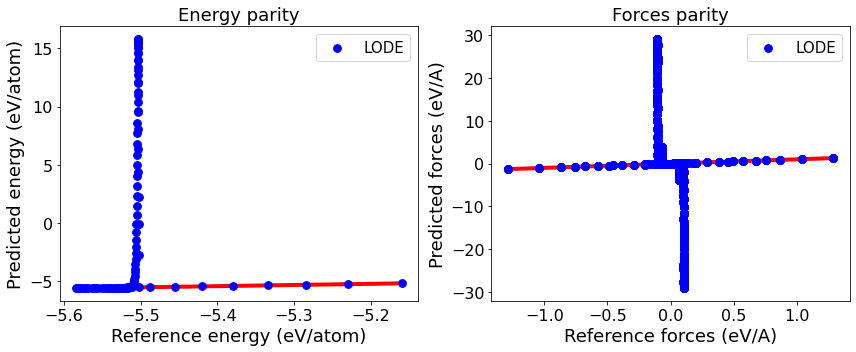

In [9]:
fig, ax = plt.subplots(1,2,figsize=(12,5))
x = [test_energy_per_atom.min(), test_energy_per_atom.max()]
ax[0].set_title('Energy parity',fontsize=18)
ax[0].set_xlabel('Reference energy (eV/atom)',fontsize=18)
ax[0].set_ylabel('Predicted energy (eV/atom)',fontsize=18)
ax[0].tick_params(labelsize=16)
ax[0].plot(x, x, color="r",linewidth=4)
ax[0].scatter(test_energy_per_atom, pred_energy_lrlr_per_atom,color='blue',label='LODE',zorder=3,s=60)
ax[0].legend(markerscale=1,fontsize=15)

xx = [test_forces.flatten().min(), test_forces.flatten().max()]
ax[1].set_title('Forces parity',fontsize=18)
ax[1].set_xlabel('Reference forces (eV/A)',fontsize=18)
ax[1].set_ylabel('Predicted forces (eV/A)',fontsize=18)
ax[1].tick_params(labelsize=16)
ax[1].plot(xx, xx, color="r",linewidth=4)
ax[1].scatter(test_forces.flatten(), pred_forces_lrlr.flatten(),color='blue',label='LODE',zorder=3,s=60)
ax[1].legend(markerscale=1,fontsize=15)

plt.tight_layout()

### annotations

# for ii in np.arange(len(test_energy_per_atom)):
#     if abs(test_energy_per_atom[ii]-pred_energy_srsr_per_atom[ii]) > 0.3:
#         ax[0].annotate(str(ii),xy=(test_energy_per_atom[ii],pred_energy_srsr_per_atom[ii]),xycoords='data',
#                       xytext=(test_energy_per_atom[ii],pred_energy_srsr_per_atom[ii]),textcoords='data',
#                       fontsize=13)
#     if abs(test_energy_per_atom[ii]-pred_energy_lrlr_per_atom[ii]) > 0.15:
#         ax[0].annotate(str(ii),xy=(test_energy_per_atom[ii],pred_energy_lrlr_per_atom[ii]),xycoords='data',
#                       xytext=(test_energy_per_atom[ii],pred_energy_lrlr_per_atom[ii]),textcoords='data',
#                       fontsize=10)
#     if abs(test_energy_per_atom[ii]-pred_energy_multi_per_atom[ii]) > 0.15:
#         ax[0].annotate(str(ii),xy=(test_energy_per_atom[ii],pred_energy_multi_per_atom[ii]),xycoords='data',
#                       xytext=(test_energy_per_atom[ii],pred_energy_multi_per_atom[ii]),textcoords='data',
#                       fontsize=13)

# for ii in np.arange(len(test_forces.flatten())):
#     frameID = ii//24
#     atomID = (ii-frameID*24)//3
#     direcID = ii-frameID*24-atomID*3
#     label = str(frameID) #+','+str(atomID)+','+str(direcID)
#     if np.abs(test_forces.flatten()[ii]-pred_forces_srsr.flatten()[ii]) > 0.45:
#         ax[1].annotate(label,xy=(test_forces.flatten()[ii],pred_forces_srsr.flatten()[ii]),xycoords='data',
#                       xytext=(test_forces.flatten()[ii],pred_forces_srsr.flatten()[ii]),textcoords='data',
#                       fontsize=11)
#     if np.abs(test_forces.flatten()[ii]-pred_forces_lrlr.flatten()[ii]) > 0.45:
#         ax[1].annotate(label,xy=(test_forces.flatten()[ii],pred_forces_lrlr.flatten()[ii]),xycoords='data',
#                       xytext=(test_forces.flatten()[ii],pred_forces_lrlr.flatten()[ii]),textcoords='data',
#                       fontsize=11)
#     if np.abs(test_forces.flatten()[ii]-pred_forces_multi.flatteneams bug, or()[ii]) > 0.45:
#         ax[1].annotate(label,xy=(test_forces.flatten()[ii],pred_forces_multi.flatten()[ii]),xycoords='data',
#                       xytext=(test_forces.flatten()[ii],pred_forces_multi.flatten()[ii]),textcoords='data',
#                       fontsize=11)

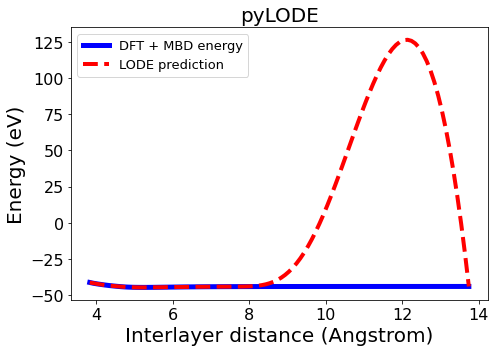

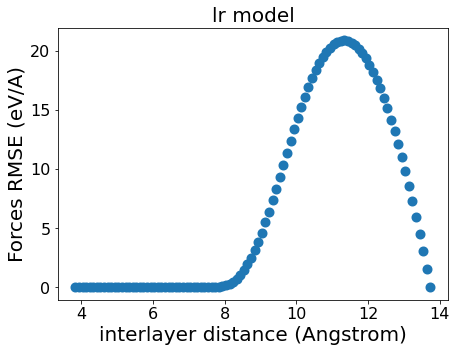

In [10]:
dist_list = []
error_forces = []

for i in np.arange(len(frames)):
    dist = frames[i].get_positions()[0,1]-frames[i].get_positions()[6,1]
    dist_list.append(dist)
    error = np.sqrt(np.sum(
        np.power( pred_forces_lrlr[8*i:8*(i+1),1:3]-test_forces[8*i:8*(i+1),1:3],2)
    )/16)
    error_forces.append(error)

fig,ax = plt.subplots(figsize=(7,5))

ax.set_xlabel('Interlayer distance (Angstrom)',fontsize=20)
ax.set_ylabel('Energy (eV)',fontsize=20)
ax.tick_params(labelsize=16)
ax.set_title('pyLODE',fontsize=20)
#ax.set_ylim(-45,-40)

ax.plot(dist_list, test_energy,'-',label='DFT + MBD energy',linewidth=5,color='blue')
ax.plot(dist_list, pred_energy_lrlr,'--',label='LODE prediction',linewidth=4,color='red')

ax.legend(markerscale=2,fontsize=13)

plt.tight_layout()

fig,ax = plt.subplots(figsize=(7,5))

ax.set_xlabel('interlayer distance (Angstrom)',fontsize=20)
ax.set_ylabel('Forces RMSE (eV/A)',fontsize=20)
ax.scatter(dist_list, error_forces,linewidth=4)
ax.set_title('lr model',fontsize=20)
ax.tick_params(labelsize=16)